In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
import keras_tuner as kt
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.neighbors import KNeighborsRegressor
import keras_tuner as kt
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('../data/ready-props-pinamar.csv')
df.isnull().sum()

precio                       0
m2                           0
ambientes                    0
dormitorios                  0
baños                        0
cocheras                     0
es_a_refaccionar             0
tiene_quincho                0
m2_construidos_final         0
pileta_m2_real               0
tiene_jardin                 0
estado_desc                  0
tiene_vista_mar              0
es_cercano_mar               0
gas_natural                  0
losa_radiante                0
porcentaje_cubierto          0
es_ph_loft                   0
estilo_antiguedad            0
tipo_detectado               0
barrio_detectado             0
m2_no_construidos            0
es_lujosa_hardware           0
ratio_bano_dormitorio        0
factor_parque                0
tiene_seguridad              0
es_moderna_estrenar          0
dependencia_servicio         0
doble_vidrio_dvh             0
cochera_cerrada              0
nivel_pileta                 0
es_renovada                  0
en_compl

In [30]:
cols_numericas = [
    'm2',
    #'m2_no_construidos', 
    'm2_construidos_final',
    'ambientes', 
    'dormitorios', 
    'baños', 
    'cocheras', 
    'nivel_pileta', 'cantidad_plantas',
    #'pileta_m2_real', 
    'ratio_bano_dormitorio',  'ambientes_extra', 'ratio_dormitorio_ambiente',
]   
    #'factor_parque' 

# B. Categóricas (Texto que define valor)
# 'barrio_detectado' es CRÍTICA. 'estado_desc' ayuda mucho.
cols_categoricas = [
    'barrio_detectado', 'estilo_antiguedad',
    #'tipo_detectado',
    'estado_desc'
]

# C. Binarias (0 o 1 - Características Clave)
# Aquí agregamos las variables "Estrella" de Pinamar que creamos recién.
cols_binarias = [
    'es_a_refaccionar', 
    'es_lujosa_hardware',  'dependencia_servicio', 'doble_vidrio_dvh', 
    #'tiene_pileta', 
    #'tiene_quincho', 
    'losa_radiante',
    'es_cercano_mar',
    #'tiene_vista_mar',  
    'gas_natural',     'es_ph_loft',
    'tiene_seguridad', 'es_renovada',  'en_complejo', 'es_moderna_estrenar'
]

cols_numericas = [c for c in cols_numericas if c in df.columns]
cols_categoricas = [c for c in cols_categoricas if c in df.columns]
cols_binarias = [c for c in cols_binarias if c in df.columns]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconocido')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_numericas),
        ('cat', categorical_transformer, cols_categoricas),
        ('bin', binary_transformer, cols_binarias) 
    ],
    verbose_feature_names_out=False 
).set_output(transform="pandas") 

In [31]:
X = df[cols_numericas + cols_categoricas + cols_binarias] 
y = df['precio']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69)

X_train_proc = preprocessor.fit_transform(X_train)

X_val_proc = preprocessor.transform(X_val)

print(f"   Shape X_train_proc: {X_train_proc.shape}")
print(f"   Shape X_val_proc:   {X_val_proc.shape}")

   Shape X_train_proc: (876, 42)
   Shape X_val_proc:   (219, 42)


In [32]:
joblib.dump(preprocessor, 'trained_models/preprocesador_pinamar.pkl')
joblib.dump((X_val, y_val), '../data/datos_validacion.pkl')
print("Preprocesador y datos de validación guardados")

Preprocesador y datos de validación guardados


In [33]:
model_lr = LinearRegression(n_jobs=-1)

model_lr.fit(X_train_proc, y_train)

y_pred_train = model_lr.predict(X_train_proc)
r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100

print(f"R2 Score (Train):       {r2_train:.4f}")
print(f"Error Promedio (Train): {mape_train:.2f}%")

joblib.dump(model_lr, 'trained_models/modelo_lineal_pinamar.pkl')

print("Modelo entrenado y guardado")

R2 Score (Train):       0.5997
Error Promedio (Train): 22.44%
Modelo entrenado y guardado


In [34]:
y_train_log = np.log1p(y_train)

model_lr = LinearRegression(n_jobs=-1)
model_lr.fit(X_train_proc, y_train_log)

y_pred_train_log = model_lr.predict(X_train_proc)

y_pred_train = np.expm1(y_pred_train_log)

r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100

print(f"R2 Score (Train):       {r2_train:.4f}")
print(f"Error Promedio (Train): {mape_train:.2f}%")

joblib.dump(model_lr, 'trained_models/modelo_lineal_log_pinamar.pkl')
print("Modelo logarítmico entrenado y guardado ")

R2 Score (Train):       0.5681
Error Promedio (Train): 21.35%
Modelo logarítmico entrenado y guardado 


In [35]:
param_dist_rf = {
    'n_estimators': [200, 300, 500],       
    'max_depth': [10, 15, 20, 25, None],       
    'min_samples_leaf': [1, 2, 4],              
    'max_features': ['sqrt', 'log2', 1.0],     
    'bootstrap': [True]
}

rf_base = RandomForestRegressor(random_state=69)

search_rf_normal = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=20,                                    
    scoring='neg_mean_absolute_percentage_error',  
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=69
)
search_rf_normal.fit(X_train_proc, y_train)

best_rf_normal = search_rf_normal.best_estimator_

y_pred_train_rf = best_rf_normal.predict(X_train_proc)
mape_train_rf = mean_absolute_percentage_error(y_train, y_pred_train_rf) * 100

print(f"Mejor Config. Normal: {search_rf_normal.best_params_}")
print(f"MAPE Train: {mape_train_rf:.2f}%")

joblib.dump(best_rf_normal, 'trained_models/modelo_rf_opt_pinamar.pkl')

y_train_log = np.log1p(y_train)

search_rf_log = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring='neg_mean_squared_error', 
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
search_rf_log.fit(X_train_proc, y_train_log)

best_rf_log = search_rf_log.best_estimator_

y_pred_train_log = best_rf_log.predict(X_train_proc)
y_pred_train_rf_log = np.expm1(y_pred_train_log)
mape_train_rf_log = mean_absolute_percentage_error(y_train, y_pred_train_rf_log) * 100

print(f"Mejor Config. Logarítmica: {search_rf_log.best_params_}")
print(f"MAPE Train: {mape_train_rf_log:.2f}%")

joblib.dump(best_rf_log, 'trained_models/modelo_rf_log_opt_pinamar.pkl')

print("\nAmbos modelos optimizados, entrenados y guardados")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejor Config. Normal: {'n_estimators': 300, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': None, 'bootstrap': True}
MAPE Train: 10.90%
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejor Config. Logarítmica: {'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': None, 'bootstrap': True}
MAPE Train: 7.75%

Ambos modelos optimizados, entrenados y guardados


Reloading Tuner from tuner_dir/house_pricing_tuning/tuner0.json
Mejor configuración encontrada:
 - Neuronas Capa 1: 64
 - Dropout Capa 1: 0.4
 - Neuronas Capa 2: 128
 - Dropout Capa 2: 0.4
 - Learning Rate: 0.01
Epoch 1/500


/Users/juanmanuel/Desktop/proyectoMl/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.3373 - val_loss: 1.2429
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4150 - val_loss: 0.9758
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8665 - val_loss: 0.8609
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9038 - val_loss: 1.9089
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5983 - val_loss: 0.9746
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3763 - val_loss: 1.2476
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3280 - val_loss: 0.6420
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1076 - val_loss: 0.4075
Epoch 9/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9970 - val_loss: 0.9798
Epoch 10/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8827 - val_loss: 0.4083
Epoch 11/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8099 - val_loss: 0.3400
Epoch 12/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7475 - val_lo

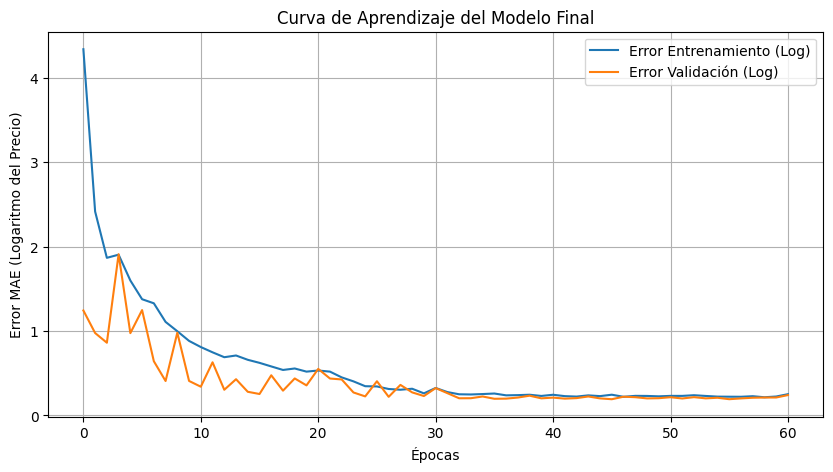

In [36]:
y_train_log = np.log1p(y_train)
y_val_log = np.log(y_val)

input_dim = X_train_proc.shape[1]

def build_model(hp):
    model = Sequential()
    
    # Capa de Entrada + Oculta 1 (Buscando entre 64 y 256 neuronas)
    model.add(Dense(
        units=hp.Int('units_1', min_value=64, max_value=256, step=64),
        activation='relu',
        input_shape=(input_dim,)
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.4, step=0.1)))
    
    # Capa Oculta 2 (Buscando entre 32 y 128 neuronas)
    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.4, step=0.1)))
    
    # Capa Oculta 3 fija para estabilizar antes de la salida
    model.add(Dense(32, activation='relu'))
    
    # Capa de Salida: 1 neurona lineal para el Log(Precio)
    model.add(Dense(1, activation='linear'))
    
    # Optimizador: Buscando el mejor Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_absolute_error' # Evaluamos el error sobre el logaritmo
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,    
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='house_pricing_tuning'
)

early_stop_tuner = EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    X_train_proc, y_train_log,
    validation_data=(X_val_proc, y_val_log),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_tuner],
    verbose=0 
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model_nn = tuner.hypermodel.build(best_hps)

print(f"Mejor configuración encontrada:")
print(f" - Neuronas Capa 1: {best_hps.get('units_1')}")
print(f" - Dropout Capa 1: {best_hps.get('dropout_1')}")
print(f" - Neuronas Capa 2: {best_hps.get('units_2')}")
print(f" - Dropout Capa 2: {best_hps.get('dropout_2')}")
print(f" - Learning Rate: {best_hps.get('learning_rate')}")

# ENTRENAR EL MODELO FINAL
early_stop_final = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model_nn.fit(
    X_train_proc, y_train_log,
    validation_data=(X_val_proc, y_val_log),
    epochs=500,          
    batch_size=32,       
    callbacks=[early_stop_final],
    verbose=1            
)

y_pred_log_train = model_nn.predict(X_train_proc).flatten()
y_pred_train = np.expm1(y_pred_log_train)

y_pred_log_val = model_nn.predict(X_val_proc).flatten()
y_pred_val = np.exp(y_pred_log_val)

def print_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mediana = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"{dataset_name.upper()}")
    print(f"R2 Score:        {r2:.4f}")
    print(f"Error Promedio:  {mape:.2f}%")
    print(f"Error Mediano:   {mediana:.2f}%")

print("RESULTADOS RED NEURONAL (En USD)")
print_metrics(y_train, y_pred_train, "Train")
print_metrics(y_val, y_pred_val, "Validation")

# Gráfico de pérdida (Loss) en escala logarítmica
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Error Entrenamiento (Log)')
plt.plot(history.history['val_loss'], label='Error Validación (Log)')
plt.title('Curva de Aprendizaje del Modelo Final')
plt.xlabel('Épocas')
plt.ylabel('Error MAE (Logaritmo del Precio)')
plt.legend()
plt.grid(True)
plt.show()

resultados_nn = pd.DataFrame({
    'Precio Real USD': y_val.values,
    'Predicción NN USD': y_pred_val.round(0),
    'Diferencia USD': (y_val.values - y_pred_val).round(0),
    'Error %': ((y_pred_val - y_val.values) / y_val.values * 100).round(1)
})
model_nn.save('trained_models/modelo_nn_pinamar.keras')

In [37]:
y_train_log = np.log1p(y_train)
input_dim = X_train_proc.shape[1]

def build_model(hp):
    model = Sequential()
    
    # Capa de Entrada + Oculta 1
    model.add(Dense(
        units=hp.Int('units_1', min_value=64, max_value=256, step=64),
        activation='relu',
        input_shape=(input_dim,)
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.4, step=0.1)))
    
    # Capa Oculta 2
    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.4, step=0.1)))
    
    # Capa Oculta 3 fija
    model.add(Dense(32, activation='relu'))
    
    # Capa de Salida (Lineal para el Logaritmo del Precio)
    model.add(Dense(1, activation='linear'))
    
    # Optimizador
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_absolute_error'
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='house_pricing_tuning'
)

early_stop_tuner = EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    X_train_proc, y_train_log,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_tuner],
    verbose=0 
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model_nn = tuner.hypermodel.build(best_hps)

early_stop_final = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model_nn.fit(
    X_train_proc, y_train_log,
    validation_split=0.2,         
    epochs=500,          
    batch_size=32,       
    callbacks=[early_stop_final],
    verbose=1            
)
model_nn.save('trained_models/modelo_casas_pinamar.keras')
print("\nModelo guardado")

Reloading Tuner from tuner_dir/house_pricing_tuning/tuner0.json
Epoch 1/500


/Users/juanmanuel/Desktop/proyectoMl/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7742 - val_loss: 2.6313
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5948 - val_loss: 2.3178
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1465 - val_loss: 1.0863
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1135 - val_loss: 0.9659
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8378 - val_loss: 2.5581
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7647 - val_loss: 0.8153
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4553 - val_loss: 0.7256
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4162 - val_loss: 0.8550
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2177 - val_loss: 1.0320
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3344 - val_loss: 0.8036
Epoch 11/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1222 - val_loss: 0.4593
Epoch 12/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9846 - val_lo

In [38]:
y_train_log = np.log1p(y_train)
input_dim = X_train_proc.shape[1]

def build_robust_model(hp):
    model = Sequential()
    
    # Entrada Grande 
    model.add(Dense(
        units=hp.Int('units_1', min_value=128, max_value=512, step=128), 
        input_shape=(input_dim,)
    ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01)) # alpha es el equivalente moderno a negative_slope
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Capa Intermedia
    model.add(Dense(
        units=hp.Int('units_2', min_value=64, max_value=256, step=64)
    ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Compresión 
    model.add(Dense(
        units=hp.Int('units_3', min_value=32, max_value=128, step=32)
    ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.3, step=0.1)))
    
    # Ajuste Fino 
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.01))
    
    #  SALIDA 
    model.add(Dense(1, activation='linear'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3])
    
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate), 
        loss='mean_absolute_error'
    )
    return model

tuner = kt.RandomSearch(
    build_robust_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_robust_dir',
    project_name='house_pricing_robust_tuning'
)

early_stop_tuner = EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    X_train_proc, y_train_log,
    validation_split=0.2, 
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_tuner],
    verbose=0 
)

# ENTRENAR EL MODELO FINAL
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model_v2 = tuner.hypermodel.build(best_hps)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=0.00001,
    verbose=1
)

early_stop_final = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True
)

history_v2 = model_v2.fit(
    X_train_proc, y_train_log,
    validation_split=0.2,          
    epochs=300,          
    batch_size=64,       
    callbacks=[early_stop_final, reduce_lr],
    verbose=1            
)

model_v2.save('trained_models/modelo_robusto_pinamar.keras')
print("\nModelo robusto guardado")

Reloading Tuner from tuner_robust_dir/house_pricing_robust_tuning/tuner0.json
Epoch 1/300


/Users/juanmanuel/Desktop/proyectoMl/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/juanmanuel/Desktop/proyectoMl/.venv/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.9843 - val_loss: 7.6491 - learning_rate: 0.0100
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1332 - val_loss: 7.7082 - learning_rate: 0.0100
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5187 - val_loss: 6.3935 - learning_rate: 0.0100
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3671 - val_loss: 3.6491 - learning_rate: 0.0100
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1522 - val_loss: 4.4984 - learning_rate: 0.0100
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1291 - val_loss: 3.4514 - learning_rate: 0.0100
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1585 - val_loss: 3.1700 - learning_rate: 0.0100
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0825 - val_loss: 2.6331 - learning_rate: 0.0100
Epoch 9/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0385 - val_loss: 2.4861 - learning_rate: 0.0100
Epoch 10/300
11/11 ━━━━━━━━━━━

In [39]:
y_train_log = np.log1p(y_train)

param_dist = {
    'n_estimators': [500],        
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],                   
    'min_samples_leaf': [1, 2, 4],               
    'subsample': [0.8, 0.9, 1.0],                
    'max_features': ['sqrt', 'log2', None]       
}

gb_base = GradientBoostingRegressor(random_state=42)

# ENTRENAMIENTO TARGET CRUDO (USD Reales)
random_search_raw = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=param_dist,
    n_iter=30,             
    scoring='neg_mean_absolute_percentage_error',
    cv=3,                  
    verbose=1,
    n_jobs=-1,             
    random_state=42
)

random_search_raw.fit(X_train_proc, y_train)
best_gb_raw = random_search_raw.best_estimator_

print("\nMejor config (Crudo):", random_search_raw.best_params_)
joblib.dump(best_gb_raw, 'trained_models/modelo_gb_crudo_pinamar.joblib')
print("Modelo crudo guardado'")

# ENTRENAMIENTO TARGET LOGARÍTMICO
random_search_log = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=param_dist,
    n_iter=30,             
    scoring='neg_mean_absolute_error', 
    cv=3,                  
    verbose=1,
    n_jobs=-1,             
    random_state=42
)

random_search_log.fit(X_train_proc, y_train_log)
best_gb_log = random_search_log.best_estimator_

print("\nMejor config (Logaritmo):", random_search_log.best_params_)
joblib.dump(best_gb_log, 'trained_models/modelo_gb_log_pinamar.joblib')
print("Modelo logarítmico guardado")

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejor config (Crudo): {'subsample': 0.9, 'n_estimators': 500, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.05}
Modelo crudo guardado'
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejor config (Logaritmo): {'subsample': 0.8, 'n_estimators': 500, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.05}
Modelo logarítmico guardado


In [40]:
y_train_log = np.log1p(y_train)

param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21], 
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan'],  
    'p': [1, 2]                            
}

knn_base = KNeighborsRegressor(n_jobs=-1)

# ENTRENAMIENTO TARGET CRUDO (USD Reales)
random_search_raw = RandomizedSearchCV(
    estimator=knn_base,
    param_distributions=param_dist,
    n_iter=20,            
    scoring='neg_mean_absolute_percentage_error',
    cv=3,                  
    verbose=1,
    random_state=42
)

random_search_raw.fit(X_train_proc, y_train)
best_knn_raw = random_search_raw.best_estimator_

print("\nMejor config (Crudo):", random_search_raw.best_params_)
joblib.dump(best_knn_raw, 'trained_models/modelo_knn_crudo_pinamar.joblib')
print("Modelo crudo guardado")

# ENTRENAMIENTO 2: TARGET LOGARÍTMICO
random_search_log = RandomizedSearchCV(
    estimator=knn_base,
    param_distributions=param_dist,
    n_iter=20,             
    scoring='neg_mean_absolute_error', 
    cv=3,                  
    verbose=1,
    random_state=42
)

random_search_log.fit(X_train_proc, y_train_log)
best_knn_log = random_search_log.best_estimator_

print("\n Mejor config (Logaritmo):", random_search_log.best_params_)
joblib.dump(best_knn_log, 'trained_models/modelo_knn_log_pinamar.joblib')
print(" Modelo logarítmico guardado")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejor config (Crudo): {'weights': 'distance', 'p': 1, 'n_neighbors': 9, 'metric': 'manhattan'}
Modelo crudo guardado
Fitting 3 folds for each of 20 candidates, totalling 60 fits

 Mejor config (Logaritmo): {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'metric': 'euclidean'}
 Modelo logarítmico guardado
